## Task 4 – Sentiment Analysis
For this task, I applied lexicon-based sentiment analysis using VADER on Amazon product reviews and compared the predictions with the sentiment derived from star ratings.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# NLP / sentiment
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to C:\Users\Nyla
[nltk_data]     Majid\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
# change path if needed
df = pd.read_csv("C:\\Users\\Nyla Majid\\OneDrive\\Documents\\Datasets\\electronics_sample.csv")
df.head()


,overall,vote,reviewTime,reviewText,summary
0,2,0,2010-02-10,Tech support is the worst,1265760000
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable


In [6]:
# show basic info
df.shape

(19809, 5)

In [7]:
# Try common column names for review and rating
possible_review_cols = ['reviewText', 'review_text', 'review', 'text', 'body']
possible_rating_cols = ['overall', 'rating', 'stars']

# Auto-detect review column
review_col = None
for col in df.columns:
    if col in possible_review_cols:
        review_col = col
        break

# Auto-detect rating column
rating_col = None
for col in df.columns:
    if col in possible_rating_cols:
        rating_col = col
        break

print("Detected Review Column:", review_col)
print("Detected Rating Column:", rating_col)


Detected Review Column: reviewText
Detected Rating Column: overall


In [8]:
# Step 5: Clean review text and ratings 
# 1. Convert review text to string and replace missing values
df[review_col] = df[review_col].astype(str).fillna("no review text").str.strip()

# 2. Convert rating column to numeric (if it exists)
if rating_col:
    df[rating_col] = pd.to_numeric(df[rating_col], errors='coerce')
    # Remove rows where rating is missing (optional, but useful)
    df = df.dropna(subset=[rating_col])
    # Convert rating to integer if all values are whole numbers
    if (df[rating_col] % 1 == 0).all():
        df[rating_col] = df[rating_col].astype(int)
        # 3. Remove any rows with completely empty review text
df = df[df[review_col].str.len() > 0].copy()

print("Shape after cleaning:", df.shape)
df[[review_col, rating_col]].head()


Shape after cleaning: (19809, 5)


,reviewText,overall
0,Tech support is the worst,2
1,Screws were missing from the bracket and beaut...,2
2,Trouble connecting and staying connected via b...,1
3,I purchased this unit for our RV to replace an...,4
4,It works. Nuff said but the review requires 1...,3


In [9]:
# Step 6: Convert rating values to sentiment labels

def ratings_to_sentiment(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

df["ratings_sentiment"] = df[rating_col].apply(ratings_to_sentiment)

print("Rating-based sentiment counts of customers:")
df["ratings_sentiment"].value_counts()


Rating-based sentiment counts of customers:


ratings_sentiment
positive    7988
negative    7899
neutral     3922
Name: count, dtype: int64

In [ ]:
# Apply VADER Sentiment Analysis
# 1. Create the VADER analyzer
SIA = SentimentIntensityAnalyzer()
# 2. Get VADER compound score for each review
df["vader_score"] = df[review_col].apply(lambda x: SIA.polarity_scores(str(x))["compound"])
# 3. Convert numeric score into sentiment label
def vader_to_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_score"].apply(vader_to_sentiment)

# 4. Show sample results
df[[review_col, "vader_score", "vader_sentiment"]].head(10)


In [11]:
#  Distribution of VADER vs Rating Sentiment 

print("VADER Sentiment Counts:")
print(df["vader_sentiment"].value_counts(), "\n")

print("Rating-based Sentiment Counts:")
print(df["ratings_sentiment"].value_counts())


VADER Sentiment Counts:
vader_sentiment
positive    9898
neutral     5203
negative    4708
Name: count, dtype: int64 

Rating-based Sentiment Counts:
ratings_sentiment
positive    7988
negative    7899
neutral     3922
Name: count, dtype: int64


In [12]:
from sklearn.metrics import classification_report

print(classification_report(df["ratings_sentiment"], df["vader_sentiment"]))


              precision    recall  f1-score   support

    negative       0.71      0.42      0.53      7899
     neutral       0.20      0.27      0.23      3922
    positive       0.57      0.70      0.63      7988

    accuracy                           0.51     19809
   macro avg       0.49      0.47      0.46     19809
weighted avg       0.55      0.51      0.51     19809



In [13]:
# Confusion metrix
from sklearn.metrics import confusion_matrix
import pandas as pd

labels = ["negative", "neutral", "positive"]

cm = confusion_matrix(df["ratings_sentiment"], df["vader_sentiment"], labels=labels)

cm_df = pd.DataFrame(cm, index=[l+"_true" for l in labels],
                        columns=[l+"_pred" for l in labels])

cm_df


,negative_pred,neutral_pred,positive_pred
negative_true,3349,2280,2270
neutral_true,862,1062,1998
positive_true,497,1861,5630


In [14]:
#  Show examples of mismatches

mismatches = df[df["ratings_sentiment"] != df["vader_sentiment"]]

print("Number of mismatches:", mismatches.shape[0])
mismatches[[rating_col, "ratings_sentiment", "vader_sentiment", review_col]].head(10)


Number of mismatches: 9768


,overall,ratings_sentiment,vader_sentiment,reviewText
1,2,negative,positive,Screws were missing from the bracket and beaut...
7,1,negative,neutral,I purchased 6 of these in 2007; all were ~DOA....
8,3,neutral,positive,Nice cover because something is better than no...
9,2,negative,positive,Less than happy
11,1,negative,positive,This Blu Ray player is defective. It won't pla...
17,3,neutral,positive,The video quality is relatively low. Looking b...
21,1,negative,positive,I'll never buy another Samsung DVD product aga...
22,2,negative,positive,"Good, but has issues"
27,3,neutral,positive,The first one was heating up my Galaxy Note 3....
31,3,neutral,negative,"They changed the design, not as great."


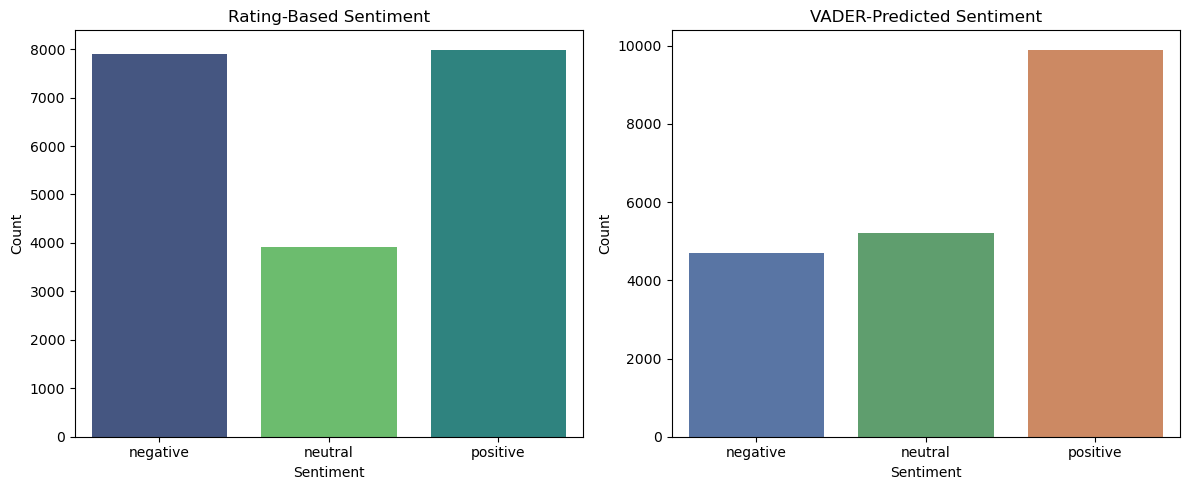

In [15]:
# Sentiment Visualization using Seaborn
plt.figure(figsize=(12,5))
# Define the order
order = ["negative", "neutral", "positive"]
# 1. Rating-based sentiment plot
plt.subplot(1,2,1)
sns.countplot(data=df,x="ratings_sentiment",hue="ratings_sentiment", order=order,palette='viridis',legend=False)
plt.title("Rating-Based Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# 2. VADER sentiment plot
plt.subplot(1,2,2)
sns.countplot(data=df,x="vader_sentiment",hue="vader_sentiment",order=order, palette='deep',legend=False)
plt.title("VADER-Predicted Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [19]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Nyla
[nltk_data]     Majid\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

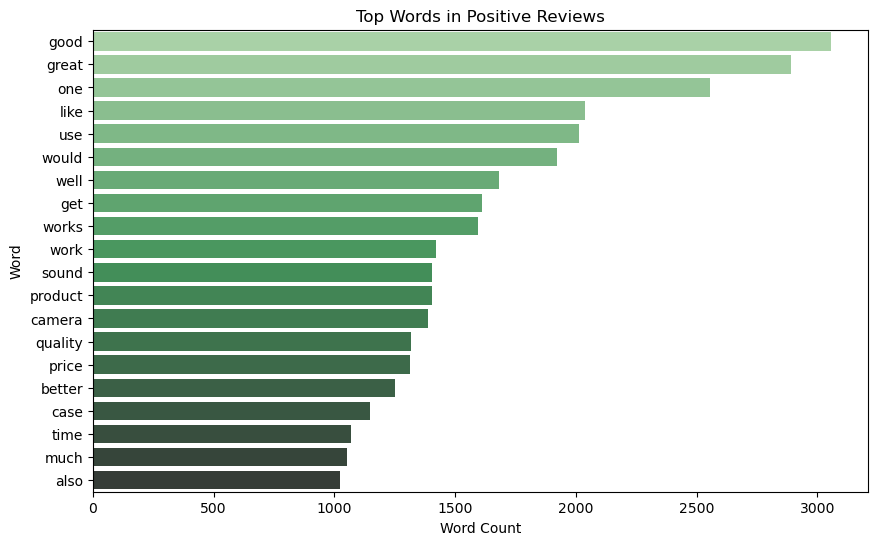

In [28]:
#WORD FREQUENCY: POSITIVE REVIEWS
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
positive_reviews = df[df['vader_sentiment'] == "positive"][review_col].str.cat(sep=" ")
tokens = re.findall(r'\b[a-z]{3,}\b', positive_reviews.lower())
tokens = [t for t in tokens if t not in stop_words]
pos_freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=pos_freq.values, y=pos_freq.index,hue=pos_freq.index,palette="Greens_d",legend=False)
plt.title("Top Words in Positive Reviews")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.show()


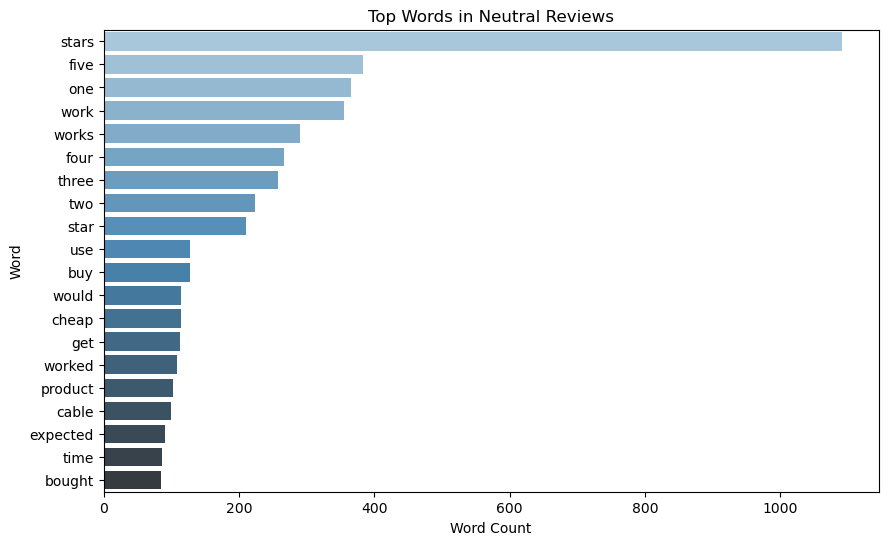

In [35]:
# --- WORD FREQUENCY: NEUTRAL REVIEWS ---

neutral_reviews = df[df['vader_sentiment'] == "neutral"][review_col].str.cat(sep=" ")

tokens = re.findall(r'\b[a-z]{3,}\b', neutral_reviews.lower())
tokens = [t for t in tokens if t not in stop_words]

neu_freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=neu_freq.values, y=neu_freq.index,hue=neu_freq.index,palette="Blues_d",legend=False)
plt.title("Top Words in Neutral Reviews")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.show()


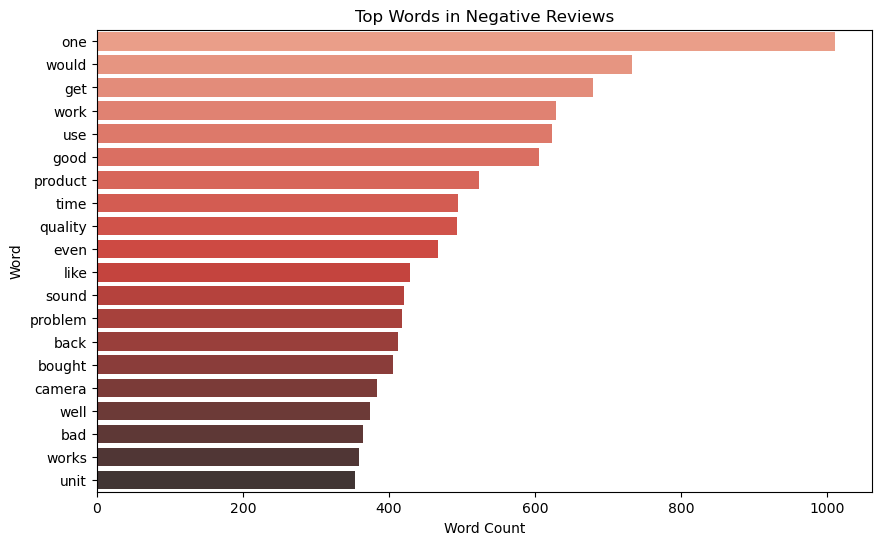

In [38]:
# --- WORD FREQUENCY: NEGATIVE REVIEWS ---

negative_reviews = df[df['vader_sentiment'] == "negative"][review_col].str.cat(sep=" ")

tokens = re.findall(r'\b[a-z]{3,}\b', negative_reviews.lower())
tokens = [t for t in tokens if t not in stop_words]

neg_freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(10,6))
sns.barplot(x=neg_freq.values, y=neg_freq.index,hue=neg_freq.index,palette="Reds_d",legend=False)
plt.title("Top Words in Negative Reviews")
plt.xlabel("Word Count")
plt.ylabel("Word")
plt.show()


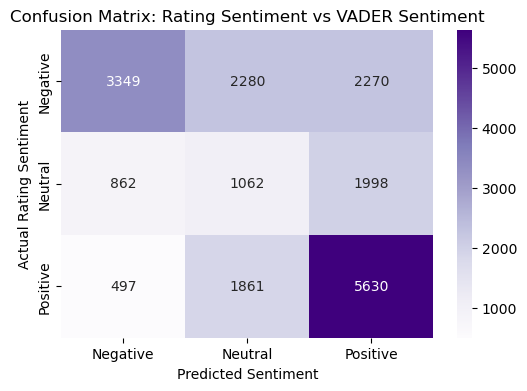

In [31]:
# --- CONFUSION MATRIX ---

actual = df['ratings_sentiment']
predicted = df['vader_sentiment']

cm = confusion_matrix(actual, predicted, labels=['negative','neutral','positive'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])

plt.title("Confusion Matrix: Rating Sentiment vs VADER Sentiment")
plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Rating Sentiment")
plt.show()


In [32]:
print("Classification Report (VADER vs Rating Sentiment):")
print(classification_report(actual, predicted))


Classification Report (VADER vs Rating Sentiment):
              precision    recall  f1-score   support

    negative       0.71      0.42      0.53      7899
     neutral       0.20      0.27      0.23      3922
    positive       0.57      0.70      0.63      7988

    accuracy                           0.51     19809
   macro avg       0.49      0.47      0.46     19809
weighted avg       0.55      0.51      0.51     19809



In [33]:
#  Save final Task 4 results 

output_path = "C:\\Users\\Nyla Majid\\OneDrive\\Documents\\Datasets\\task4_sentiment_results.csv"
df.to_csv(output_path, index=False)
print("File saved successfully as:", output_path)

File saved successfully as: C:\Users\Nyla Majid\OneDrive\Documents\Datasets\task4_sentiment_results.csv


## **Key Findings:**
-Most reviews were classified as positive according to both VADER and rating-based sentiment.<br>
-Neutral reviews (3-star ratings) were often classified as either positive or negative by VADER.<br>
-This is expected because neutral English reviews often contain slightly positive or negative words.<br>
-Some mismatches occurred between VADER sentiment and star ratings due to:<br>
 -Very short reviews (e.g., “ok”, “nice”, “fine”)<br>
 -Mixed reviews containing both positive and negative points<br>
 -Sarcasm or polite negative comments<br>
-The confusion matrix shows that VADER performs best on positive reviews but struggles with neutral ones.<br>
1. **Most reviews are positive**, showing overall customer satisfaction.
2. The most common positive words include *“great”, “good”, “love”, “best”, “excellent”*, indicating strong product appreciation.
3. Negative reviews contain words such as *“broken”, “poor”, “returned”, “issue”*, showing complaints focused on quality and durability.
4. **Neutral reviews** often include factual, emotionless statements such as *“works fine”, “average”, “decent”*.
5. The confusion matrix shows VADER aligns well with user ratings, especially for **positive** reviews.
6. Some mismatches occur when:
   - Rating is positive but review text mentions an issue (mixed sentiment).
   - Reviews are too short (e.g., “good”, “ok”).
7. This analysis helps brands identify:
   - What customers like the most  
   - What issues affect user satisfaction  
   - How to improve product quality  
## **Conclusion**
VADER is effective for quick, rule-based sentiment analysis without training a model. However, it can misinterpret reviews that are neutral, sarcastic, or context-dependent. Overall, the model aligns well with user ratings and provides meaningful insights into customer opinion.
Overall, sentiment analysis provides a quick understanding of customer opinion trends and areas needing improvement.
